# 一、描述符计算模块
## 1.rdkit.Chem.Lipinski模块
rdkit中提供了许多描述符的计算方法，可用于分子筛选、成药性评估等。以lipinski类药的相关规则为例，可以通过rdkit.Chem.Lipinski模块进行计算。常用的一些性质举例：
* 氢键受体数NumHAcceptors
* 氢键供体数NumHDonors
* 可旋转键数NumRotatableBonds
* 脂肪环数量NumAliphaticRings
* 芳香环数量NumAromaticRings
* SP3杂化碳原子比例FractionCSP3
* ……

In [1]:
from rdkit import Chem
from rdkit.Chem import Lipinski
mol = Chem.MolFromSmiles('c1ccccc1C(=O)O')
Lipinski.NumHAcceptors(mol)

1

* 将描述符名称(key)和值(val)添加到分子属性中：m.SetProp(key, val)
* 获取分子属性：m.GetProp(key)

In [2]:
Ha = Lipinski.NumHAcceptors(mol)
mol.SetProp('Ha', '%s'%Ha)
mol.GetProp('Ha')

'1'

## 2.rdkit.Chem.Descriptors模块
大部分的描述符都可以通过rdkit.Chem.Descriptors模块进行计算。该模块也包含了Lipinski的描述符。常用的一些描述符举例：
* 分子量MolWt
* 脂水分配系数MolLogP
* 拓扑极表面积TPSA
* 以计算TPSA为例：Descriptors.TPSA()

In [3]:
from rdkit.Chem import Descriptors
print(Descriptors.TPSA(mol), Descriptors.MolLogP(mol), Descriptors.MolWt(mol))

37.3 1.3848 122.12299999999998


## 3.rdkit.ML.Descriptors.MoleculeDescriptors模块
* 先指定一个列表des_list，包含所要计算的描述符名称，
* 使用MolecularDescriptorCalculator创建一个计算描述符的对象，传入要计算的des_list
* 调用对象的CalcDescriptors方法，传入要计算的mol对象，得到所需的描述符

In [4]:
from rdkit.ML.Descriptors import MoleculeDescriptors
des_list = ['MolWt', 'NumHAcceptors', 'NumHDonors', 'MolLogP', 'NumRotatableBonds']
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(des_list)
calculator.CalcDescriptors(mol)

(122.12299999999998, 1, 1, 1.3848, 1)

* 查看各种描述符的含义：GetDescriptorSummaries()

In [5]:
calculator.GetDescriptorSummaries()

['The average molecular weight of the molecule',
 'Number of Hydrogen Bond Acceptors',
 'Number of Hydrogen Bond Donors',
 'Wildman-Crippen LogP value',
 'Number of Rotatable Bonds']

* 获取所有描述符：Descriptors._descList

In [6]:
des_list = [x[0] for x in Descriptors._descList]
len(des_list)

200

* 将calculator保存起来SaveState(filename)
* 再次调用该calculator：pickle.load()

In [7]:
import pickle
calculator.SaveState('data/descriptor_calculator')
with open('data/descriptor_calculator', 'rb') as f:
    calc = pickle.load(f)
calc.CalcDescriptors(mol)

(122.12299999999998, 1, 1, 1.3848, 1)

# 二、原子描述符可视化
可以用相似性地图来查看每个原子对描述符的贡献，更多相似性地图的应用可以查看[这篇文章](https://blog.csdn.net/dreadlesss/article/details/106129597)的第二部分。

## 1.原子partial charge可视化

计算[partial charge](http://www.colby.edu/chemistry/PChem/scripts/MarvinWebold/chemaxon/marvin/help/Charge.html)要复杂一点。计算出的partial charge存储在每个原子的属性中，可以通过GetDoubleProp（浮点数）或GetProp（字符串）来获取。

partial charge可以表示电子的分布。分子中的化学键是由分布在相连原子周围的电子对组成的。但由于原子的电负性不同，成键电子并不是均匀分布。电负性大的原子吸电子能力强，成键的电子对会更偏向该原子，导致该原子带有负电的性质。相对应的，电负性小的原子则带有正电性质。Partial charge衡量了电子偏向的程度。

* 先计算partial charge：AllChem.ComputeGasteigerCharges()
* 获取某一个原子：GetAtomWithIdx()
* 获取原子的partial charge：GetDoubleProp('_GasteigerCharge')

In [8]:
from rdkit.Chem import AllChem
mol = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
AllChem.ComputeGasteigerCharges(mol)
atom = mol.GetAtomWithIdx(0)
atom.GetDoubleProp('_GasteigerCharge')

0.07771844728655561

* 获取每个原子的partial charge，放到contribs中

[0.08, -0.49, 0.16, -0.02, -0.06, -0.05, 0.02, -0.0, 0.19, 0.29, -0.27, -0.35, 0.02, -0.03, -0.04, -0.0, -0.3, 0.02, 0.03, -0.37, 0.07, -0.04, -0.06, -0.03, 0.09, -0.25, 0.05, 0.05, -0.25, 0.11, 0.03, 0.02, -0.45, 0.18]


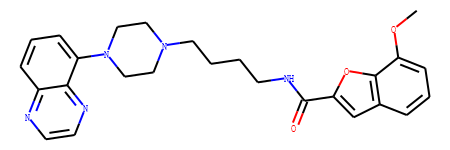

In [9]:
contribs = [round(mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge'), 2) for i in range(mol.GetNumAtoms())]
print(contribs)
mol

* 根据给定的权重，生成分子权重图GetSimilarityMapFromWeights(mol, weights, colorMap, contourLines, ...)<br />
mol：要绘制的mol对象<br />
weights：权重<br />
colorMap：matplotlib中的色系<br />
contourLines：等高线数量

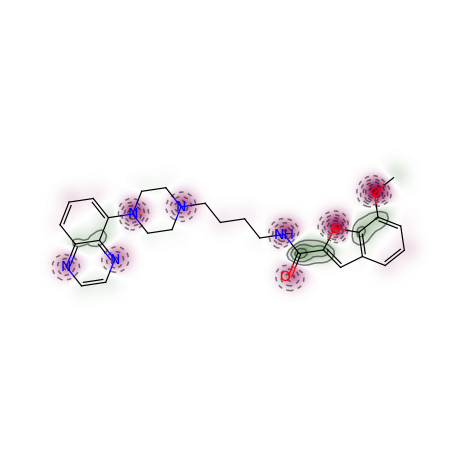

In [11]:
from rdkit.Chem.Draw import SimilarityMaps
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, contourLines=10)

In [12]:
fig.savefig('data/descriptor_visulize1.png', bbox_inches='tight')

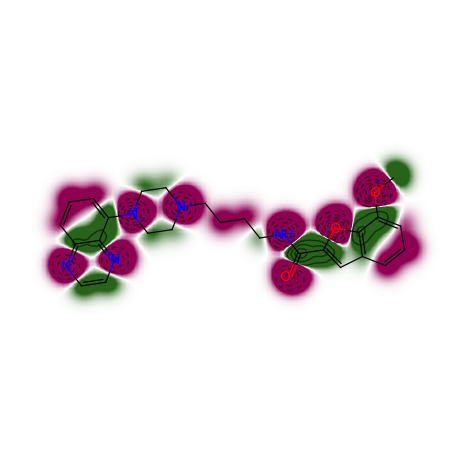

In [13]:
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, scale=10)

## 2.原子logP可视化
LogP表示脂水分配系数，该值认为与细胞通透性有一定相关性。rdkit中提供的Descriptors.MolLogP()方法可以粗略计算logP值，该方法首先做了一个原子分类系统，根据原子及其相连原子的不同而进行分类，再对化学性质相似、logP贡献相似的类别做合并，最终得到了68种精确的原子类别和4种通配类别，并用SMARTS表示。计算时，对一个分子中所有原子进行分类，再乘以每一类的权重并加和，最终得到LogP值。该方法在9920个分子的训练集上的r2为0.918，标准差为0.667。此外摩尔折射率（molar refractivity，MR）也可以通过这种方法计算得到。

* 计算每个原子的logP和MR值：rdMolDescriptors._CalcCrippenContribs<br />
返回结果是每个原子logP和MR元组的列表

In [14]:
from rdkit.Chem import rdMolDescriptors
contribs = rdMolDescriptors._CalcCrippenContribs(mol)
contribs[:3]

[(-0.2035, 2.753), (-0.4195, 1.182), (0.5437, 3.853)]

* 生成分子权重图：GetSimilarityMapFromWeights()

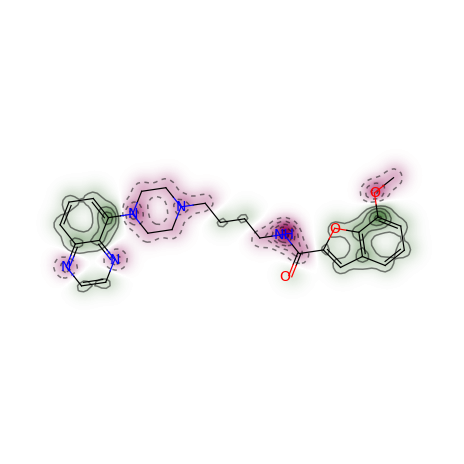

In [15]:
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, [x for x,y in contribs])

In [16]:
fig.savefig('data/descriptor_visulize2.png', bbox_inches='tight')